# CS 345 Final Project - Predicting SWE using ML

### Ian Hay-Arthur, Joseph Thompson

## Part 1 Daily SWE Predictions

## Introduction and Dataset

The dataset used in this project is data generated by the USDA's SNOTEL station network. This network comprises weather stations throughout Colorado and measure weather data daily. The list of SNOTEL sights in Colorado can be found at [here](https://wcc.sc.egov.usda.gov/nwcc/yearcount?network=sntl&state=CO&counttype=statelist), with the report generator for these stations found [here](https://wcc.sc.egov.usda.gov/reportGenerator/). One of the key datapoints that these stations provide is snow water equivalent or SWE. SWE is a measure of the amount of water stored in the snowpack. Because water is so scarce throughought the mountain west, SWE serves as an important measure of this resource. Below is a sample SWE yearly chart for the Independence Pass SNOTEL station:

<img style="padding: 10px; float:center;" alt="broadcasting" src="independence_pass-co-wteq-por.png" width="600">

These stations constantly record a large number of features, so the first step we decided on using SWE (in inches) as our label and the following features:

| Feature | Unit | 
| ------- | ---- |
| Date | Year, Month, Day |
| Snow Depth | Inches |
| Precipitation Accumulation | Inches |
| Precipitation Increment | Inches | 
| Precipitation Month-To-Date | Inches |
| Air Temperature Average | Degrees Fahrenheit |
| Air Temperature Maximum | Degrees Fahrenheit |
| Air Temperature Minimum | Degrees Fahrenheit |

This dataset included the date of observations in the form of Year-Month-Day which was split into three different features, one for year, month, and day.

The result of this was a dataset with the size of (~16000, 10) per individual Snotel site, with the number of rows depending on how long each station has been active.

Additionally this dataset including a large amount of missing data, this was a result of some features only being active for certain periods of a stations lifecycle leading to incomplete data. Our solution to this was removing any rows of data that contained absent information. This was because we had no shortage of data for our purposes and thus would perfer any data used to be of the best quality.

The goal of this section is to read in data from different Snotel sites to create a regression model to predict the daily snow water equivelent based on that days features. We will read in each of these Snotel sites individually and run a variety of regression models on each of these ddatasets to determine which of the models are the best for this regression.

Each of these regression models uses a grid search which combines K-fold cross validation and hyperparameter sweeping to determine the best model on a given training set based on model accuracy. This means that the models given for each of the following datasets have the best hyperparameters for the dataset in the given grid, and have been tested on all values in the training dataset.

## Key Utility Functions
These functions include:
* Key library imports
* A CSV data loader to load data
* A MAE function for model verfication
* A ridge regression model
* A SVM model
* A random forest model
* A MLP regression model
* A helper function that trains all 5 models and returns perfomance metrics

For our various ML models we are using Griding to tune hyper parameters with train and test set split of 30%.

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd
from sklearn.decomposition import PCA



In [13]:
# Reads in a csv file
# Removes all rows that do not contain all of the features
# Takes the date vector and converts it into 3 vectors  of Year, Month, Day
def readData(filename):
    fileData = np.loadtxt(filename, delimiter=",", dtype=str)
    fileData = fileData[np.all(fileData != '', axis=1)]

    def split_date(date_str):
        year, month, day = date_str.split('-')
        return int(year), int(month), int(day)
    
    vectorized_split_date = np.vectorize(split_date)
    
    dates = fileData[1:, 0]
    years, months, days = vectorized_split_date(dates)
    
    date_array = np.column_stack((years, months, days))
        
    X = fileData[1:, 1:]
    X = X.astype("float64")

    X = np.hstack((date_array, X))

    y = X[:, 3]
    X = X[:, [0,1,2,4,5,6,7,8,9,10]]

    return X, y

independancePassData, independancePassLabels = readData("IndependencePass.csv")
towerData, towerLabels = readData("Tower.csv")
bearLakeData, bearLakeLabels = readData("BearLake.csv")
copperMountainData, copperMountainLabels = readData("CopperMountain.csv")
arapahoRidgeData, arapahoRidgeLabels = readData("ArapahoRidge.csv")

In [14]:
def calculateMAE(prediction, test):
    return metrics.mean_absolute_error(prediction, test)

In [31]:
def runRidgeRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid):
    if runGrid:
        paramGrid = [
            {
                "alpha" : [.001, .01, .1, 1, 10, 100]
            }
        ]
        ridgeReg = GridSearchCV(Ridge(), paramGrid)
        ridgeReg.fit(dataTrain, labelsTrain)
        dataPred = ridgeReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), ridgeReg.best_params_
    else:
        ridgeReg = Ridge(alpha=100)
        ridgeReg.fit(dataTrain, labelsTrain)
        dataPred = ridgeReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), "alpha: 100"
    

In [32]:
def runSVMRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid):
    if runGrid:
        paramGrid = [
            {
                "C" : [1, 10, 100, 1000, 10000],
                "gamma" : [.00001 ,.0001, .001],
                "kernel" : ["rbf", "linear"]
            }
        ]
        svmReg = GridSearchCV(SVR(), paramGrid) 
        svmReg.fit(dataTrain, labelsTrain)
        dataPred = svmReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), svmReg.best_params_
    else:
        svmReg = SVR(C=100000, gamma=.00001, kernel="rbf") 
        svmReg.fit(dataTrain, labelsTrain)
        dataPred = svmReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), "C: 10000, gamma: .00001, kernal: rbf"

In [33]:
def runForestRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid):
    if runGrid:
        paramGrid = [
            {
                "n_estimators" : [50, 100, 150, 200],
                "max_depth" : [2, 5, 10, 20, None],
            }
        ]
        forestReg = GridSearchCV(RandomForestRegressor(), paramGrid)
        forestReg.fit(dataTrain, labelsTrain)
        dataPred = forestReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), forestReg.best_params_
    else:
        forestReg = RandomForestRegressor(n_estimators=100, max_depth=None)
        forestReg.fit(dataTrain, labelsTrain)
        dataPred = forestReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), "n_estimators: 100, max_depth: None"

In [34]:
def runMLPRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid):
    if runGrid:
        paramGrid = [
            {
                "hidden_layer_sizes": [(50,), (100,), (150,)],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.001, 0.01, 0.1],
                "learning_rate": ["constant", "adaptive"]
            }
        ]
        mlpReg = GridSearchCV(MLPRegressor(), paramGrid)
        mlpReg.fit(dataTrain, labelsTrain)
        dataPred = mlpReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), mlpReg.best_params_
    else:
        mlpReg = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes= (150,), learning_rate= 'constant', solver= 'adam')
        mlpReg.fit(dataTrain, labelsTrain)
        dataPred = mlpReg.predict(dataTest)
        return calculateMAE(dataPred, labelsTest), "activation: relu, alpha: 0.001, hidden_layer_sizes 150, learning_rate: constant, solver: adam"

In [460]:
def runAverageRegression(labelsTrain, labelsTest):
    dataPredMean = np.zeros(labelsTest.shape[0])
    dataPredMean.fill(np.mean(labelsTrain))
    return calculateMAE(dataPredMean, labelsTest)


In [35]:
def runData(data, labels, runGrid):
    dataTrain, dataTest, labelsTrain, labelsTest = train_test_split(data, labels, test_size=.3)
    aveReg = runAverageRegression(labelsTrain, labelsTest)
    ridgeReg = runRidgeRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid)
    svmReg = runSVMRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid)
    forestReg = runForestRegression(dataTrain, dataTest, labelsTrain, labelsTest, runGrid)
    mlpReg = runMLPRegression(dataTrain, dataTest, labelsTrain, labelsTest, False)
    results = [
        ['Average Regression', aveReg, "N/A"],
        ['Ridge Regression', ridgeReg[0], ridgeReg[1]],
        ['SVM Regression', svmReg[0], svmReg[1]],
        ['Forest Regression', forestReg[0], forestReg[1]],
        ['MLP Regression', mlpReg[0], mlpReg[1]],

    ]

    return results


### Feature Analysis

Text(0.5, 1.0, 'Air Temperature Minimum vs SWE')

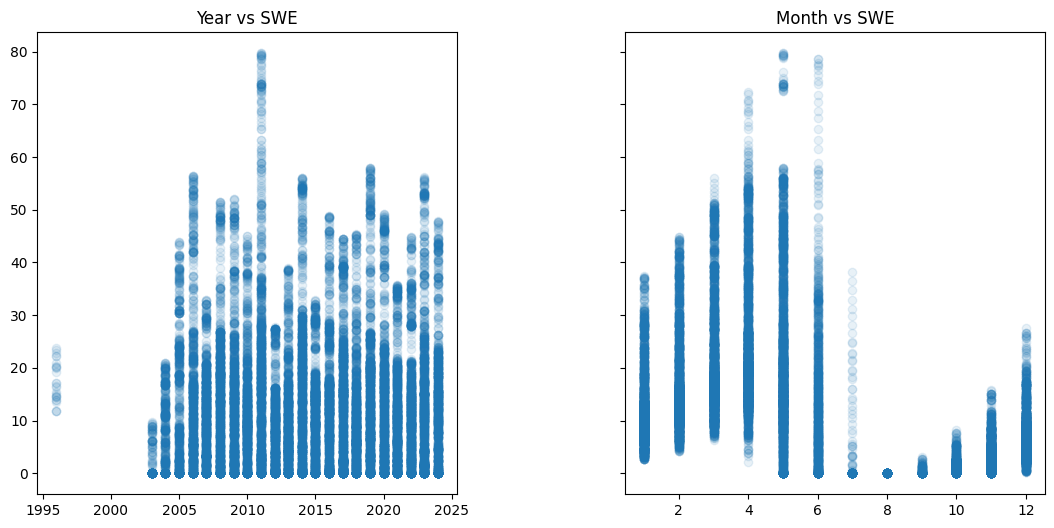

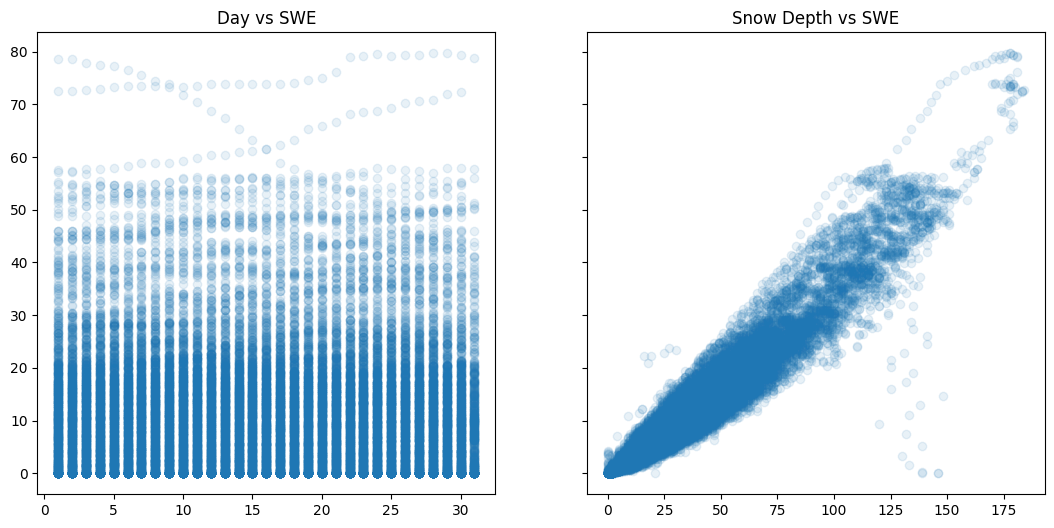

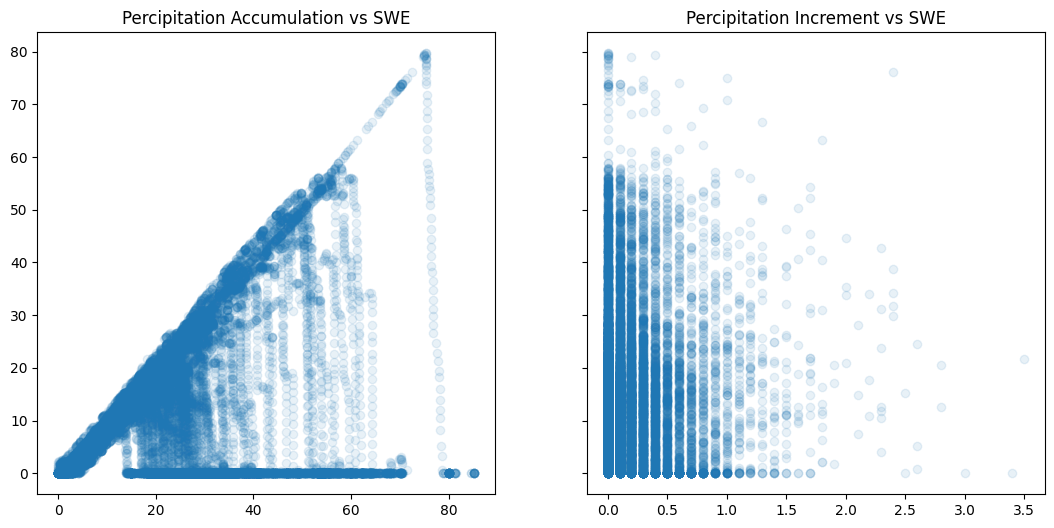

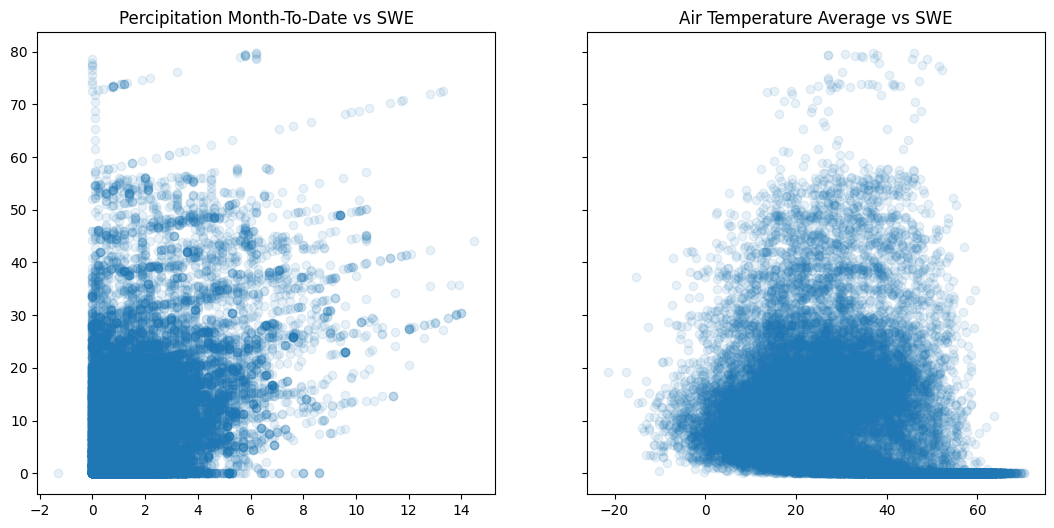

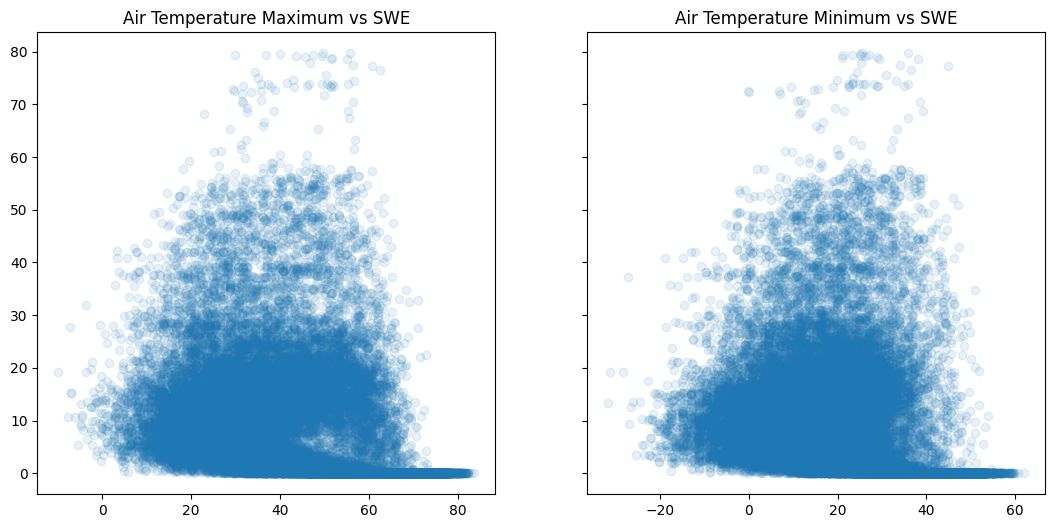

In [21]:
cumlativeData = np.vstack((independancePassData, towerData, bearLakeData, copperMountainData, arapahoRidgeData))
cumlativeLabels = np.hstack((independancePassLabels, towerLabels, bearLakeLabels, copperMountainLabels, arapahoRidgeLabels))

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(13,6))
plt.subplots_adjust(hspace=1, wspace=0.4)
axes[0].scatter(cumlativeData[:, 0], cumlativeLabels, alpha=0.1);
axes[0].set_title("Year vs SWE")
axes[1].scatter(cumlativeData[:, 1], cumlativeLabels, alpha=0.1);
axes[1].set_title("Month vs SWE")
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(13,6))
axes[0].scatter(cumlativeData[:, 2], cumlativeLabels, alpha=0.1);
axes[0].set_title("Day vs SWE")
axes[1].scatter(cumlativeData[:, 3], cumlativeLabels, alpha=0.1);
axes[1].set_title("Snow Depth vs SWE")
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(13,6))
axes[0].scatter(cumlativeData[:, 4], cumlativeLabels, alpha=0.1);
axes[0].set_title("Percipitation Accumulation vs SWE")
axes[1].scatter(cumlativeData[:, 5], cumlativeLabels, alpha=0.1);
axes[1].set_title("Percipitation Increment vs SWE")
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(13,6))
axes[0].scatter(cumlativeData[:, 6], cumlativeLabels, alpha=0.1);
axes[0].set_title("Percipitation Month-To-Date vs SWE")
axes[1].scatter(cumlativeData[:, 7], cumlativeLabels, alpha=0.1);
axes[1].set_title("Air Temperature Average vs SWE")
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(13,6))
axes[0].scatter(cumlativeData[:, 8], cumlativeLabels, alpha=0.1);
axes[0].set_title("Air Temperature Maximum vs SWE")
axes[1].scatter(cumlativeData[:, 9], cumlativeLabels, alpha=0.1);
axes[1].set_title("Air Temperature Minimum vs SWE")


In [22]:
# Testing random forest to see the coefficient matrix
cumlativeDataTrain, cumlativeDataTest, cumlativeLabelsTrain, cumlativeLabelsTest = train_test_split(cumlativeData, cumlativeLabels, test_size=.3)
cumlativeForestRegression = RandomForestRegressor(n_estimators=200, max_depth=None)
cumlativeForestRegression.fit(cumlativeDataTrain, cumlativeLabelsTrain)
featureImportance = cumlativeForestRegression.feature_importances_
featureLabels = ["Year", "Month", "Day", "Snow Depth", "Percipitation Accumulation", "Percipitation Increment", "Percipitation Month-To-Date", "Air Temperature Average", "Air Temperature Maximum", "Air Temperature Minimum"]
features = np.array(featureLabels)
featureImportance = np.column_stack((featureLabels, featureImportance))
pd.DataFrame(featureImportance, columns = ["Feature", "Importance"])

,Feature,Importance
0,Year,0.0019935375000975277
1,Month,0.004411641528129196
2,Day,0.0006818712359337811
3,Snow Depth,0.7403005354640468
4,Percipitation Accumulation,0.24720375271291478
5,Percipitation Increment,0.00019332773117452804
6,Percipitation Month-To-Date,0.0010951681558110805
7,Air Temperature Average,0.001031297926766095
8,Air Temperature Maximum,0.000625296503171132
9,Air Temperature Minimum,0.0024635712419550228


After combining all 5 Snotel sites into one comulative array we created scatter plots of each feature and their relationship to SWE. Some interesting standouts from these scatterplots is how July and August have such low SWE equivalent values, snow depth has such a near linear relationship to SWE, and percipitation accumulation has a split between a linear realationship and a flat relationship with SWE. If we apply this cumlative dataset to a random forest model we can see that the snow depth and precipitation accumulation have by far the largest effect on the SWE compared to the other features. Assuming you trained a Random Forest regression model with only snow depth and percipitation accumulation it appears it would have a near equivalent accuracy to a model trained with all features.

## Selecting Key Features
SNOTEL stations output a large number of features. Therefore, the first step of this process is to select which features should be used to train our ML model. To begin, we used PCA analysis to select the most distinctive features for determinging *daily* SWE. The goal is to use as few features as possible while maintaining a reasonable MAE across our models. This is so we can eliminate noise variables and improve model training time.


In order to test our implementations of various ML algorithyms, ensure data quailty, and inform model selection. We ran these tests on the Independence Pass, Tower, Bear Lake, Copper Mountain, and Arapaho Ridge SNOTEL Stations. The goal of these tests was to predict daily SWE using the other features measured by the station that day.

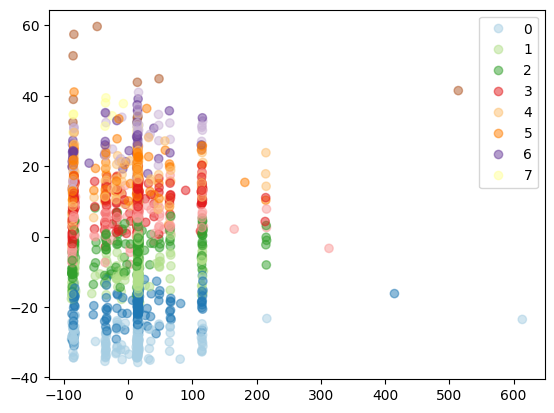

In [23]:
independancePassData, independancePassLabels = readData("FeatureSelection/IndependencePass.csv")

pca = PCA(independancePassData.shape[1])
indyPassPCA = pca.fit_transform(independancePassData)
scatter=plt.scatter(indyPassPCA[:, 0], indyPassPCA[:, 1], alpha=0.5, c=independancePassLabels, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(8));


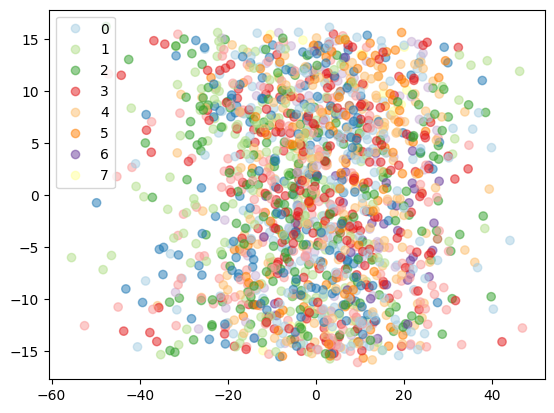

In [24]:
scatter=plt.scatter(indyPassPCA[:, 2], indyPassPCA[:, 3], alpha=0.5, c=independancePassLabels, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(8));

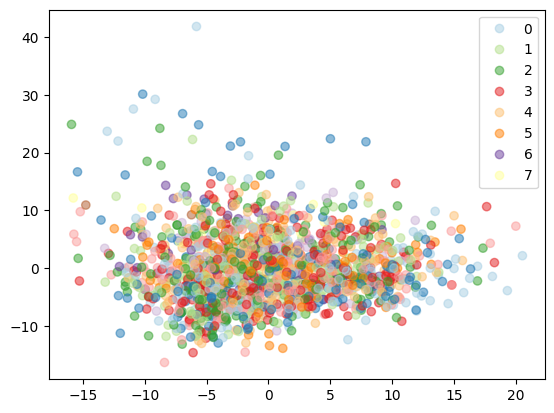

In [25]:
scatter=plt.scatter(indyPassPCA[:, 4], indyPassPCA[:, 5], alpha=0.5, c=independancePassLabels, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(8));

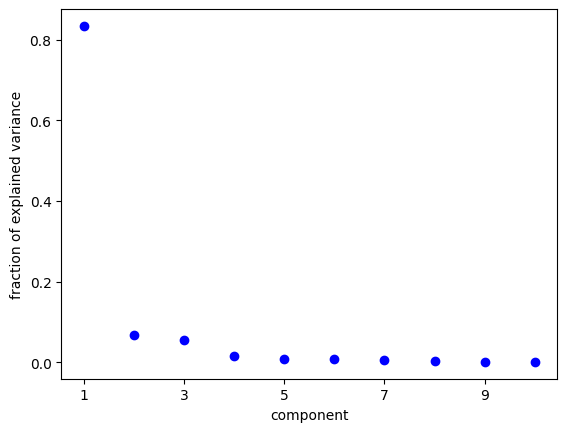

In [26]:
plt.plot(range(1, independancePassData.shape[1] + 1), pca.explained_variance_ratio_, 'ob')
plt.xlabel("component")
plt.xticks(range(1,independancePassData.shape[1]+1, 2))
plt.ylabel("fraction of explained variance");

Looking at this PCA breakdown it is clear that the only one component of the PCA is required to explain the vast majority of the variance. From there the second and third components still have some effects on the total varience but far less significantly tham the first component. This makes sense because if you look at the feature importance above there is one feature (snow depth) that has the most significance for this regression model. Therefore it is easy to say that it is mostly that feature that allows for one component to explain the large majority of the varience in this data 

In [37]:
results = runData(independancePassData, independancePassLabels, False)
pd.DataFrame(results, columns = ["Classifier", "Mean Absolute Error", "Grid Parameters"])

,Classifier,Mean Absolute Error,Grid Parameters
0,Average Regression,4.691263,N/A
1,Ridge Regression,0.787230,alpha: 100
2,SVM Regression,0.046629,"C: 10000, gamma: .00001, kernal: rbf"
3,Forest Regression,0.297427,"n_estimators: 100, max_depth: None"
4,MLP Regression,0.405357,"activation: relu, alpha: 0.001, hidden_layer_s..."


In [38]:
results = runData(towerData, towerLabels, False)
pd.DataFrame(results, columns = ["Classifier", "Mean Absolute Error", "Grid Parameters"])

,Classifier,Mean Absolute Error,Grid Parameters
0,Average Regression,15.688912,N/A
1,Ridge Regression,2.451998,alpha: 100
2,SVM Regression,0.877332,"C: 10000, gamma: .00001, kernal: rbf"
3,Forest Regression,0.464413,"n_estimators: 100, max_depth: None"
4,MLP Regression,1.298059,"activation: relu, alpha: 0.001, hidden_layer_s..."


In [ ]:
results = runData(bearLakeData, bearLakeLabels, False)
pd.DataFrame(results, columns = ["Classifier", "Mean Absolute Error", "Grid Parameters"])

,Classifier,Mean Absolute Error,Grid Parameters
0,Average Regression,6.628426,N/A
1,Ridge Regression,1.282808,alpha: 100
2,SVM Regression,0.538061,"C: 10000, gamma: .00001, kernal: rbf"
3,Forest Regression,0.275983,"n_estimators: 100, max_depth: None"
4,MLP Regression,0.791973,"activation: relu, alpha: 0.001, hidden_layer_s..."


In [40]:
results = runData(copperMountainData, copperMountainLabels, False)
pd.DataFrame(results, columns = ["Classifier", "Mean Absolute Error", "Grid Parameters"])

,Classifier,Mean Absolute Error,Grid Parameters
0,Average Regression,5.466461,N/A
1,Ridge Regression,1.265411,alpha: 100
2,SVM Regression,0.396287,"C: 10000, gamma: .00001, kernal: rbf"
3,Forest Regression,0.178316,"n_estimators: 100, max_depth: None"
4,MLP Regression,0.509682,"activation: relu, alpha: 0.001, hidden_layer_s..."


In [41]:
results = runData(arapahoRidgeData, arapahoRidgeLabels, False)
pd.DataFrame(results, columns = ["Classifier", "Mean Absolute Error", "Grid Parameters"])

,Classifier,Mean Absolute Error,Grid Parameters
0,Average Regression,7.839691,N/A
1,Ridge Regression,1.250767,alpha: 100
2,SVM Regression,0.324829,"C: 10000, gamma: .00001, kernal: rbf"
3,Forest Regression,0.195937,"n_estimators: 100, max_depth: None"
4,MLP Regression,2.291892,"activation: relu, alpha: 0.001, hidden_layer_s..."


### Station Analysis

Looking at each of the above stations it indicates a pretty clear trend of random forest regression being the best model for predicting daily SWE execept for independance pass where SVM was more accurate.This makes a lot of sense because the random forrest ensemble method works really well with large datasets with a smaller number of features. This is because each layer of a decision tree uses a single feature to make a decision which makes it effective when there are less features compared to the data size. Furthermore the SVM model performs similarly well only being slightly less accurate compared to the forrest regression. This is not surprising as the SVM model is a very flexable model when its hyper parameters are tuned correctly and often has accurate regressions. However because the SVM performed so much better than the ridge regression model with a gaussian kernal, it is clear than the regression is non linear. Finally the MLP regression model did poorly across all sites, this is likely because the hyper parameters for this model were not properly tuned for this dataset, as the MLP model has a large number of hyperparameters that make it difficult to use the GridSearch for. That being said because of the large difference between the average regression and the Ridge/MLP regression in terms of mean absolute error, both models are atleast somewhat effective in predicting the label data.

Looking at the stations individually, it is clear that the tower dataset is the hardest to use the regession model on and has the largest variability. This can be seen from the highest mean absolute error accross the other sites between the average error and all of the regression models.

### Conclusion

In this part we explored developing different regression models to predict daily SWE based on a 10 features from 5 different Snotel weather stations. In our exploration we determined that one feature above others (Snow Depth) was responsible for the majority of the varience in our data. This can be seen in the feature importance caluclations from a cumlative random forest model and from our experiments with PCA. After creating different regression models for all of the different stations we found that the random forrest regression model was the most effective in predicting SWE effectivly on average. This is not suprising due to the relatively low number of features (Compared to datapoints) in our dataset which tends to allow random forest to thrive compared to other methods. However a small outlier was the SVM model which outperformed the random forest in the indpenedence pass data resulting in the lowest MAE across all models. It had a MAE of .0466 compared to the average 4.69 derived from guessing just the average SWE, or in other words over a 100x improvement. These results show that our methods for developing a regression model for this data was effective.

From this exploration it became very clear to us the requirements of sweeping hyperparameters to improve regression models performance. This became abundantly clear when changes in our hyperparameters changed the MAE of our results by orders of magnitudes. Moreover, it was enlightening to play around with feature analysis, including graphing each of the features individually, calculating their importance, and using PCA, because it gave a pretty clear image of what features were playing a role in the regression models outputs. If I were to repeat this experiment I would attempt to improve the MLP model because although we did not get impressive results from this model, I think it could be improved by tweaking its implentation more and sweeping its hyperparameters better than using a pure grid search.


## Part 2 Yearly SWE Predictions

## Dataset and Introduction

In this part we are taking a different approach to using the same dataset as before. In the previous part we took data from 5 different Snotel sites and used them as a basis to create a variety of regression models to predict the daily SWE based on a single days features. In this part we are trying to predict the maximum SWE experienced by a Snotel site in a year. To do this we manipulated the data to into arrays where each year was a single row, with features for each daily measurement for each day of the months observed. When reading the data we can change which months are read in when creating the dataset allowing us to predict data from months in the future (Ex: reading data from July - January to predict maximum SWE - which is often in April).

The result of this was a variable dataset depending on what we would like to test, often in the around the size of (~40, ~2000) per station with rows being each year recorded by the station, and a variable number of features depending on how many days we would like to use in our predictions. Because of the small number of rows in our dataset, we did not want to remove rows with empty values in their features, so we set all empty values to 0 to perserve as many rows of data as possible.

One of the benefits of choosing our dataset this way is it allows us manipulate how many features we use in our prediction to see how each subsequent month effects our predictions. Our hope with this approach is replicating how real life SWE predictions are made for the following water year by weather prediction systems.

In [ ]:
def readYearlyData(filename, daysToCount):
    fileData = np.loadtxt(filename, delimiter=",", dtype=str)
    fileData[fileData == ''] = 0

    def split_date(date_str):
        year, month, day = date_str.split('-')
        return int(year), int(month), int(day)
    
    vectorized_split_date = np.vectorize(split_date)
    
    dates = fileData[1:, 0]
    years, months, days = vectorized_split_date(dates)
    
    date_array = np.column_stack((years, months, days))
        
    X = fileData[1:, 1:-1]
    X = X.astype("float64")

    X = np.hstack((date_array, X))

    X = X[~((X[:, 1] == 2) & (X[:, 2] == 29))]

    X = X[: , 3:]

    bigMatrix = X[0:daysToCount , :].reshape(1, -1)
    labels = np.max(X[0:365 , 0])
    SWE = X[0:365 , 0]
    X = X[365:, :]
    while X.shape[0] > 365:
        bigMatrix = np.vstack((bigMatrix, X[0:daysToCount , :].reshape(1, -1)))
        labels = np.vstack((labels, np.max(X[0:365 , 0])))
        SWE = np.vstack((SWE, X[0:365 , 0]))
        X = X[365:, :]

    labels = labels[:, 0]



    return labels, bigMatrix, SWE

newIndependencePassData = readYearlyData("NewIndependencePass.csv", 365)

## SARIMA
A common method to predict future values is autoregressive integrated moving average ARIMA. This can be extend to seasonal trends like the snowpack through seasonal ARIMA or SARIMA. The tricky part of this method is the large number of parameters that have to be selects. Here is a table of all the important hyper parameters:

| Hyperparamer | Description | 
| ------- | ---- |
| p | Model Autoregressive Order|
| d | Model Differencing Order |
| q | Model Moving Average Order |
| P | Seasonal Autoregressive Order|
| D | Seasonal Differencing Order |
| Q | Seasonal Moving Average Order |
| s | Number of days per season (set by hand) |

To solve this, we tuned hyperparameters in two steps:
* Using single year data to select p, d, and q
* Use multiple years of data to select P, D, and Q

Please note that the auto_arima mehtod can theoreticially find all six of these values *BUT* did not perfrom very well when implemented. 

The first step is executed below. For each station trains on every indivual year and then tests on the remaining to find the maximum yearly MAE. Then the model of p, d, and q between the 5 stations is selected. The goal of this method is to find proper values of p, d, and q without overfitting them to a particual Station/Year combination:

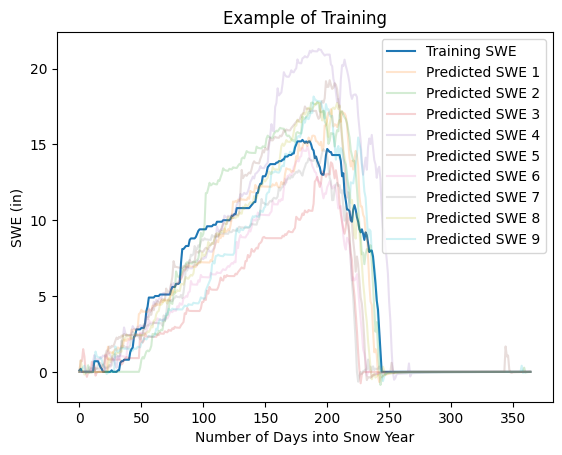

In [466]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import warnings


def findAIRMAparams(csv, plot):
    num_years = 10
    data = readYearlyData(csv, 365)
    SWEdata = data[2][-num_years:]
    #print(SWEdata.shape)
    
    average_MAE = calculateMAE(np.average(SWEdata,axis=1), data[0][-num_years:])

    # train on every year:
    p_best = 0
    q_best = 0
    d_best = 0
    mae_best = 10000

    for i in range(num_years):
        model = pm.auto_arima(SWEdata[i],n_jobs=-1, seasonal=True, stepwise=False, trace=False);
        p, d, q = model.order
        remaining_years = np.delete(SWEdata, i, axis=0)

        mae = np.zeros(num_years-1)

        start = 0
        end = 365

        if (plot == True and i == 0):
            plt.plot(np.arange(start,end),SWEdata[i], label = "Training SWE")

        for j in range(remaining_years.shape[0]):

            year = remaining_years[j]
            model = SARIMAX(year, order = (p, d, q), );
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(disp=0);

            predictions = result.predict(start, end-1);

            if (plot == True and i == 0):
                plt.plot(np.arange(start,end),predictions, alpha = 0.2, label = f"Predicted SWE {j+1}")


            from statsmodels.tools.eval_measures import rmse
            mae[j] = calculateMAE([max(predictions)], [max(year)])
        
        
        
        if np.average(mae) < mae_best:
            mae_best = np.average(mae)
            p_best = p
            q_best = q
            d_best = d 

    if (plot == True):
        plt.legend()
        plt.title("Example of Training")
        plt.ylabel("SWE (in)")
        plt.xlabel("Number of Days into Snow Year")
        plt.show()



    return [csv[:-4],round(average_MAE,3),round(mae_best,3), p_best, d_best, q_best]
                              
results1 = findAIRMAparams("IndependencePass.csv", True)
results2 = findAIRMAparams("BearLake.csv", False)
results3 = findAIRMAparams("Tower.csv", False)
results4 = findAIRMAparams("ArapahoRidge.csv", False)
results5 = findAIRMAparams("CopperMountain.csv", False)

In [467]:
results = np.vstack([results1, results2, results3, results4, results5])
pd.DataFrame(results, columns = ["Station","Average MAE","ARIMA MAE", "p", "d","q"])

,Station,Average MAE,ARIMA MAE,p,d,q
0,IndependencePass,11.535,0.149,2,1,3
1,BearLake,13.725,0.261,2,2,3
2,Tower,29.426,0.252,2,2,1
3,ArapahoRidge,15.94,0.228,2,2,2
4,CopperMountain,10.882,0.164,4,2,1


From this we can see that the model is much better than a simple average when trying to predict the maximum yearly SWE using data from the *entire year* (ie this MAE is a little optomistic but sufficent for selecting these hyperparameters). Therefore we can conclude that the optimal values of p, d, and q are all roughly 2. Next we need to find the ideal parameters for P, D and Q using a similar process. In order to make the data set managable, each station is train on 4 years of data with every 5th day sampled. The first 3 years are used to train while the 4th is used to validate.

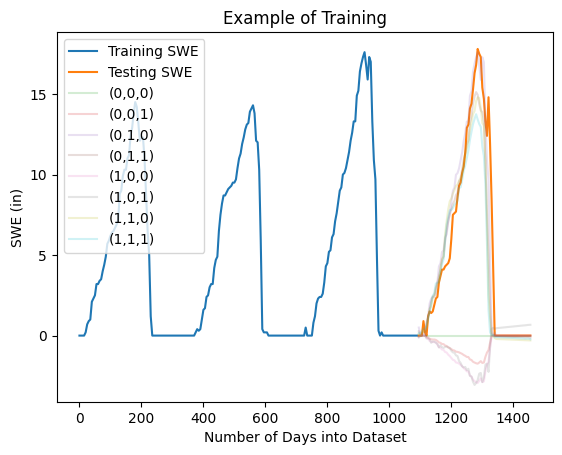

In [468]:
p_best = 2 
d_best = 2
q_best = 2

def findSeasonalparams(csv, plot):
    num_years = 4
    data= readYearlyData(csv, 365)
    SWEdata = data[2][-num_years:]

    average_MAE = calculateMAE(np.average(SWEdata,axis=1), data[0][-num_years:])

    SWEdata = SWEdata.reshape(num_years*365)
    SWEdata = SWEdata[::5]

    SWEdataTrain = SWEdata[0:(num_years-1)*73]
    SWEdataTest = SWEdata[(num_years-1)*73:]

    P_best = 0
    Q_best = 0
    D_best = 0
    mae_best = 10000

    start = 73 * (num_years-1)
    end = 73 *num_years

    if (plot == True ):
        plt.plot(np.arange(start)*5,SWEdataTrain, label = "Training SWE")
        plt.plot(np.arange(start,end)*5,SWEdataTest, label = "Testing SWE")

    number = 0
    for P in range(2):
        for D in range(2):
            for Q in range(2):
                number = number + 1

                model = SARIMAX(SWEdataTrain, order = (p_best, d_best, q_best), seasonal_order=(P,D,Q,73));

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = model.fit(disp=0);
                
                predictions = result.predict(start, end-1);


                pred_max = max(predictions)
                #plt.plot(np.arange(start),SWEdataTrain)
                if (plot == True):
                    plt.plot(np.arange(start,end)*5,predictions, label = f"({P},{D},{Q})", alpha = 0.2)
                #plt.plot(np.arange(start,end),SWEdataTest)
                # plt.show()


                mae = calculateMAE([pred_max], [max(SWEdataTest)])

                if mae < mae_best:
                    mae_best = mae
                    P_best = P
                    Q_best = Q
                    D_best = D

    if (plot == True):
        plt.legend()
        plt.title("Example of Training")
        plt.ylabel("SWE (in)")
        plt.xlabel("Number of Days into Dataset")
        plt.show()

    return [csv[:-4],round(average_MAE,3),round(mae_best,3), P_best, D_best, Q_best]
                
    
results1 = findSeasonalparams("IndependencePass.csv", True)
results2 = findSeasonalparams("BearLake.csv", False)
results3 = findSeasonalparams("Tower.csv", False)
results4 = findSeasonalparams("ArapahoRidge.csv", False)
results5 = findSeasonalparams("CopperMountain.csv", False)

In [469]:
results = np.vstack([results1, results2, results3, results4, results5])
pd.DataFrame(results, columns = ["Station","Average MAE","ARIMA MAE", "P", "D","Q"])

,Station,Average MAE,ARIMA MAE,P,D,Q
0,IndependencePass,11.302,0.216,0,1,0
1,BearLake,14.593,1.824,1,1,0
2,Tower,29.567,1.053,1,1,0
3,ArapahoRidge,15.718,0.472,1,1,1
4,CopperMountain,9.647,0.217,0,1,0


From this data we can conclude that the best values for P D and Q are 1,1, and 0 respectively. This is a rational result becasue this corresponds to a differenced autocorrelation. We can see that the MAEs have also gone down as we are using a stronger testing method, however, they are still much lower than a simlple average. With this information, we can now perform a final MAE calcuation to validate the model. To do this we use a 10 year sample. Then we do a 6 4 year subtests with 3 used to train and 1 used to test.

In [471]:
P_best = 1
D_best = 1
Q_best = 0


def AIRMAtest(csv, plot):
    num_years = 10
    subtest_years = 4
    data = readYearlyData(csv, 365)
    SWEdata = data[2][-num_years:]

    average_MAE = calculateMAE(np.average(SWEdata,axis=1), data[0][-num_years:])

    SWEdata = SWEdata.reshape(num_years*365)
    SWEdata = SWEdata[::5]

    mae = np.zeros(num_years-subtest_years)

    for i in range(num_years-subtest_years):
            SWEdataTrain = SWEdata[i*73:((i+subtest_years-1))*73]
            SWEdataTest = SWEdata[((i+subtest_years-1))*73:((i+subtest_years))*73]


            model = SARIMAX(SWEdataTrain, order = (p_best, d_best, q_best), seasonal_order=(P_best,D_best,Q_best,73));

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(disp=0);
                
            predictions = result.predict(((i+subtest_years-1))*73, ((i+subtest_years))*73-1);
    
            pred_max = max(predictions)
        
            mae[i] = calculateMAE([pred_max], [max(SWEdataTest)])

            #print(mae)
    
    return [csv[:-4],round(average_MAE,3), round(np.average(mae),3)]

results1 = AIRMAtest("IndependencePass.csv", True)
results2 = AIRMAtest("BearLake.csv", False)
results3 = AIRMAtest("Tower.csv", False)
results4 = AIRMAtest("ArapahoRidge.csv", False)
results5 = AIRMAtest("CopperMountain.csv", False)

In [472]:
results = np.vstack([results1, results2, results3, results4, results5])
pd.DataFrame(results, columns = ["Station","Average MAE","SARIMA MAE"])

,Station,Average MAE,SARIMA MAE
0,IndependencePass,11.535,4.421
1,BearLake,13.725,4.194
2,Tower,29.426,8.759
3,ArapahoRidge,15.94,3.293
4,CopperMountain,10.882,3.473


### Analysis 
From these the results we can see that the ARIMA is an decent but not increadible predictor of the yearly maximum SWE at a station. This makes sense becasue the ARIMA relies on trends to make predictions. While the seasonal progression of snow accumulating and then melting is a very predictable, the year to year change can be somewhat significant. The increased instability in this regard is evdienced by the differences in p, d, and q for the non-seasonal and seasonal part of the model:

In [473]:
pd.DataFrame([["Non-seasonal", p_best, d_best, q_best],["Seasonal", P_best, D_best, Q_best]]
             , columns = ["Model Component","p/P","d/D","q/Q"])

,Model Component,p/P,d/D,q/Q
0,Non-seasonal,2,2,2
1,Seasonal,1,1,0


Becasue the non-seasonal component of the data is more vairable, higher order terms for p,d, and q must be used while the seasonal component only used first order terms for P and D and none for Q. 

Once again, when looking at the stations individually, it is clear that the Tower dataset is still the hardest to predict and has the largest variability. It still has the highest absolute error of all the sites.

### Conclusion

In this part we explored developing a SARIMA regression model to predict the maximum yearly SWE from 5 different SNOTEL weather stations. Our final model was able to predict the maximum yearly SWE roughly 3-5 times better than simply guessing the average. As discussed the model seems to very easily detect and fit the yearly periodicity of the data but is not particulalry suited to handling the noise and variablity that can occur within one water year. 

From this exploration demonstartes how difficult it can be to predict SWE even with a large amount of data. This exlains why the USDA displays the current water year readings compated to previous years but does not try to predict future values. While the predicted values might be reasonable and better than guessing, as this exploration shows, it is likely not worth the compunational resources. If ing this experiment I would attempt to improve the SARIMA model by using a SARIMAX model. This model allows you to incorperate tangential data that can help infrom the regression model. Training a SARIMA model on mulitple seperate features like tempatures, SWE, and snowdepth and then feeding that output into one of the models developed in Part 1 might also be worth looking into. 

Ultimately, this exportation shows that SARIMA can be a powerful tool for time series fitting and projection and is an important regression tool to understand. The math behing this model is really neat too! 

## Contributions

| Project Aspect | Member | 
| -------------- | ------ |
| Part 1 Introduction and Dataset | Ian, Joseph |
| Read Data | Ian |
| Ridge Regression | Ian |
| SVM Regression | Ian | 
| Forest Regression | Ian |
| MLP Regression | Ian |
| Average Regression | Ian |
| Feature Analysis | Ian |
| Feature Importance | Ian |
| PCA | Ian, Joseph |
| Station Analysis | Ian |
| Part 1 Conclusion | Ian |
| Part 2 Introduction and Dataset | Ian, Joseph |
| Read Yearly Data | Ian, Joseph |
| Sarma Description | Joseph |
| Find AIRMA Parameters | Joseph |
| AIRMA Parameters Analysis | Joseph | 
| Find Seasonal Parmeters | Joseph |
| Seasonal Parameter Analysis | Joseph |
| Test AIRMA | Joseph | 
| AIRMA Analysis | Joseph | 
| Part 2 Conclusion | Joseph | 